In [2]:
#Importing the packages needed for this analysis
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer


%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi']= 400

In [3]:
import json
from pymongo import MongoClient

client = MongoClient()
"""db = client.legislation
tweets = db.news"""

'db = client.legislation\ntweets = db.news'

In [4]:
tastingflavors = {'Spicy':['cocoa','clove', 'vanilla','pepper', 'saffron','nutmeg','licorice','menthol','cinnamon'],\
'Char':['ash','tar','toast','wood smoke','tobacco','fireplace','burnt food','grilled food'],\
'Sweet':['malt','brown sugar','candy','honey','caramel','molasses','burnt sugar','maple syrup'],\
'Nutty':['almond', 'peanut','walnut','chestnut','hazelnut', 'roasted nuts'],\
'Floral':['rose','hops','orchid','violet','jasmine','perfume','geranium','dandelion','honeysuckle','lily of the valley','orange blossom'],\
'Herbs':['thyme','parsley','cardamom','eucalyptus','fennel seed','coriander'],\
'Vegetables':['spinach','broccoli','zucchini','asparagus','garden peas','green pepper','squash blossom'],\
'Grass':['stems','straw','barnyard','grapeseed','fresh cut grass'],\
'Wood':['evergreen','bark','cedar','resin','freshly cut wood','sawdust','wet wood','driftwood','green wood','cherry wood'],\
'Earth':['peat','moss','musty','leather','compost','wet earth','forest floor','decaying wood'],\
'Mineral':['salt', 'metalllic', 'wet rocks'],\
'Marine':['seawood','ocean air'],\
'Berry':['raspberry','strawberry','blackberry', 'black currant'],\
'Citrus':['lemon','orange','grapefruit','citrus zest'],\
'Tree Fruit':['peach','pear','apricot','apple','cooked fruit','dried fruit'],\
'Tropical':['mango','melon','lychee', 'banana','pineapple']}

wheel = {'Earthy':['Wood','Earth','Mineral','Marine'],'Vegetal':['Grass','Vegetables','Herbs'],\
         'Fruity':['Berry','Citrus','Tree Fruit','Tropical']}


In [5]:
#reading a pickle file reading to pick up where i left off in case something fails or i start over
with open("tea_data.pkl", 'rb') as picklefile: 
    teareview_dict = pickle.load(picklefile)

In [6]:
reviewcount = []
count =0
for i in teareview_dict:
    count=0
    for j in teareview_dict[i]: 
        count+=len(j['Tea Reviews'])
    reviewcount.append(count)


In [7]:
sum(reviewcount)


6931

## More Data Wrangling

Now that I have the dataframe imported, I am going to use NLP to work with the different reviews on certain teas to create more insights and set it up for unsupervised learning.

### Tasting Considerations
* Aroma: The odor of the tea liquor, also called the nose or fragrance. A complex aroma is often described as a bouquet. 
* Astringency: A lively and mouth-drying effect on the tongue. Not bitter, but a clean and refreshing quality. The sensation of astringency is caused by a reaction between polyphenols (tannins) and the protein in saliva. 
* Body: The tactile aspect of tea’s weight and substance in the mouth, variously subcategorized as light, medium, or full; also known as fullness. 
* Bright: A lively, clean style that refreshes the palate. 
* Character: A tea’s signature attributes depending upon origin, whether of its country, region or type. 
* Clean: Indicates purity of flavor and an absence of any off-tastes. 
* Finish: The lasting taste on your tongue after swallowing the tea. 
* Flowery: A floral nose or flavor associated with high grade teas. 
* Full: References a positive sensation of body and good heft; indicates a well-made tea, possessing color, strength, substance and roundness. 
* Malty: A sweet malt flavor that is characteristic of Assam black teas. 
* Muscatel: A flavor reminiscent of grapes, most often used to describe an exceptional characteristic found in the liquors of the finest Darjeelings. 
* Smooth: Round-bodied, fine-drinking teas. 
* Soft: Smooth, lush, and subsequently often (but not necessarily) timid in flavor; not a negative term. 
* Thick: Describes liquor having substance, but not necessarily strength. 
* Vegetal: A characteristic of green teas that might include grassy, herby or marine flavors.

In [8]:
import nltk
import re


In [9]:
teareview_dict['Green Tea'][0].keys()

dict_keys(['Tea Name', 'Tea Ingredients', 'Tea Flavors', 'Tea Reviews'])

### Polarity Score
Using TextBlob, I will be creating a polarity score for each review.  This is to help weight the reviews if needed. 

In [10]:
polarityscore = []
for i in teareview_dict:
    for j in teareview_dict[i]: 
        for review in j['Tea Reviews']:
            q = TextBlob(review)
            polarityscore.append(q.sentiment.polarity)
        j['Polarity']=polarityscore
        polarityscore=[]

In [11]:
teareview_dict['Black Tea'][0]['Polarity']

[0.24780701754385964,
 0.215,
 0.22731829573934836,
 0.12239389776889774,
 0.3666666666666667,
 0.32083333333333336,
 0.012499999999999999,
 0.14273268398268396,
 0.13819444444444445,
 0.2731600935828877]

### Proportion Flavor Wheel and Mouthfeel

Using the flavor wheel found online, I will create a flavor profile for each tea. I will need to use 1 and 2 n-grams and the tastingflavors dictionary.

I also want to get any 'mouthfeel' data to see what added bonus it could give to the tea. 

In [121]:
playlist = teareview_dict['Black Tea'][0]['Tea Reviews']

In [122]:
#Combining all reviews into a long string text to make it easier to pull out stop words.
#Also pulling out sentences with 'mouthfeel' to find adj for another feature.
supertext=""
mouthfeel = ''
for i in playlist:
    supertext += (' '+ i)
    if re.findall(r"([^[.!]]*?mouthfeel[^.]*\.)",i):
        print(re.findall(r"([^.!,]*?mouthfeel[^.!,]*\.)",i))
        mouthfeel=' '.join((re.findall(r"([^.!,]*?mouthfeel[^.!,]*\.)",i)))

supertext = re.sub("[’,;:–…]","", supertext).replace("(", '').replace(".", ' ').replace("!", ' ').replace(")", '')
supertext= re.sub("(-)"," ", supertext)
supertext= re.sub("(chocolate)","cocoa", supertext)

['  A very rich cup yet the mouthfeel is bright and cheery.', '  As the tea cools a bit it does become slightly thicker with a heavier mouthfeel and notes of maple syrup begin to peek through.']


In [123]:
mouthblob = TextBlob(mouthfeel)
mouthadj = []
for i in mouthblob.tags:
    if i[1]=='JJ' or i[1]=='JJR'or i[1]=='JJS':
        mouthadj.append(i[0])

In [124]:
mouthadj

['rich', 'bright', 'heavier']

In [125]:
text = TextBlob(supertext)

In [126]:
sorted(text1.word_counts.items(), key = lambda tup:tup[1], reverse = True)

[('tea', 21),
 ('notes', 8),
 ('know', 7),
 ('cocoa', 7),
 ('cup', 7),
 ('pie', 6),
 ('love', 6),
 ('black', 6),
 ('really', 6),
 ('teas', 6),
 ('there', 6),
 ('good', 5),
 ('last', 5),
 ('need', 5),
 ('sweet', 5),
 ('like', 5),
 ('day', 4),
 ('much', 4),
 ('note', 4),
 ('would', 4),
 ('vacation', 4),
 ('work', 4),
 ('also', 4),
 ('sourenee', 4),
 ('harvest', 4),
 ('the', 4),
 ('everyday', 3),
 ('yet', 3),
 ('well', 3),
 ('making', 3),
 ('made', 3),
 ('years', 3),
 ('tofu', 3),
 ('dessert', 3),
 ('several', 3),
 ('butiki', 3),
 ('sometimes', 3),
 ('wonder', 3),
 ('definitely', 3),
 ('instead', 3),
 ('bit', 3),
 ('leaves', 3),
 ('right', 3),
 ('still', 3),
 ('may', 3),
 ('another', 3),
 ('time', 3),
 ('changing', 3),
 ('golden', 3),
 ('get', 3),
 ('anyone', 3),
 ('slightly', 3),
 ('rich', 3),
 ('enough', 3),
 ('even', 3),
 ('world', 2),
 ('things', 2),
 ('grateful', 2),
 ('think', 2),
 ('minutes', 2),
 ('least', 2),
 ('wish', 2),
 ('wonderful', 2),
 ('3', 2),
 ('gluten', 2),
 ('free', 2

In [127]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
 
stop_words = stopwords.words('english')
stop_words = stop_words + ['the','i','I','a','of',')','\'', 'to', 'it','and','is','this','for', 'but', 'that', 'in', 'my', 'not','husband',\
            'be', 'we', 'are', 'm', 'as', 'just', 'there', 'you','all','with','me', 'few', 'will', 'on','has', 'was','many','last'\
              '''()''', "'",'!','.','It',',', '-',':','Thanksgiving','Im','youll','Ive','Its','Also','A','As','This','cant','anybody',\
               'go','one','everybody','dont', 'We', 'us', 'got', 'And']

word_tokens = word_tokenize(supertext)
sentence = ''
count = 0
tot_count = 0
filtered_sentence = [w for w in word_tokens if not w in stop_words]
for i in filtered_sentence:
    sentence += (' '+i)

 

print(filtered_sentence)


['Happy', 'Gratitude', 'Day', 'everyone', 'World', 'know', 'American', 'holiday', 'hope', 'everywhere', 'things', 'grateful', 'everyday', 'think', 'important', 'take', 'minutes', 'least', 'day', 'grateful', 'yet', 'wish', 'wonderful', 'things', 'lives', 'others', 'well', 'started', 'day', 'making', '3', 'pie', 'crusts', 'gluten', 'free', 'One', 'pie', 'made', 'years', 'called', 'Chocolate', 'Midnight', 'Originally', 'Chocolate', 'Almond', 'Midnight', 'praline', 'almond', 'decorative', 'topping', 'omitted', 'vegan', 'Millenium', 'Cookbook', 'decadent', 'cocoa', 'cheesecake', 'textured', 'pie', 'ever', 'eat', 'never', 'know', 'made', 'silken', 'tofu', 'know', 'believe', 'youve', 'ever', 'silken', 'tofu', '‘', 'fail', 'dessert', 'believe', 'vegan', 'years', 'years', 'tried', 'share', 'Baby', 'real', 'deal', 'people', 'fallen', 'love', 'pie', 'knowing', 'tofu', 'truth', 'found', 'didnt', 'care', 'good', 'requested', 'several', 'people', 'every', 'year', '&', 'amp', 'required', 'part', 'fam

In [128]:
text1 = TextBlob(sentence)

In [133]:
adjlist = []
for i in text1.tags:
    if i[1]=='JJ' or i[1]=='JJR'or i[1]=='JJS' or i[1]=='NN'or i[1]=='NNS':
        abb = re.sub("y","", i[0])
        if(i[0] !=abb):
            adjlist.append(abb)
            adjlist.append(i[0])
        else:
            adjlist.append(i[0])

In [138]:
text1

TextBlob(" Happy Gratitude Day everyone World know American holiday hope everywhere things grateful everyday think important take minutes least day grateful yet wish wonderful things lives others well started day making 3 pie crusts gluten free One pie made years called Chocolate Midnight Originally Chocolate Almond Midnight praline almond decorative topping omitted vegan Millenium Cookbook decadent cocoa cheesecake textured pie ever eat never know made silken tofu know believe youve ever silken tofu ‘ fail dessert believe vegan years years tried share Baby real deal people fallen love pie knowing tofu truth found didnt care good requested several people every year & amp required part family feast year took gluten crust break crust making pie filling making hearty breakfast last cup Stacys Taiwanese Assam reviewed several times bold tasty gone foresee Butiki order coming soon Sometimes need old favourite morning days let wonder tea become mere shadow true deliciousness glad dug earlier

In [137]:
re.findall(r"([^[.!]]*?mouthfeel[^.]*\.)",text1[0])

[]

In [120]:
text1.noun_phrases

WordList(['gratitude', 'american holiday hope everywhere things', 'wonderful things', 'day making', 'pie crusts gluten', 'chocolate midnight originally chocolate almond midnight', 'praline almond', 'millenium cookbook', 'decadent cocoa cheesecake', 'silken tofu', 'silken tofu ‘', 'vegan years years', 'baby', 'tofu truth', 'didnt care good', 'part family feast year', 'gluten crust', 'crust making pie filling making', 'hearty breakfast', 'stacys taiwanese assam', 'times bold tasty', 'butiki', 'old favourite morning days', 'wonder tea', 'mere shadow', 'true deliciousness', 'wowwwww', 'definitely', 'free ounce', 'strawberry oolong', 'laoshan black', 'malty cocoay theres', 'timolino', 'winner leaves', 'crazy huge thin wiry unbroken', 'fabulous', 'astringent spite', 'minutes infusion', 'rating', 'proper evaluation week', 'vacation mid week', 'work vacation', 'office closure', 'weeks time', 'real vacation', 'ton tea', 'new teas', 'sneak peek', 'hattialli', 'paw', 'hattialli', 'lionchanging', 

In [82]:
' '.join(text1.ngrams(n=2))

'Happy Gratitude'

In [139]:
def pullInfo(text1):
    count=0
    tot_count=0
    proportion_dict = {}
    for i in tastingflavors:
        count=0
        for j in text1.tags:
            if i[1]=='JJ' or i[1]=='JJR'or i[1]=='JJS' or i[1]=='NN'or i[1]=='NNS':
                abb = re.sub("y","", i[0])
                if(i[0] !=abb):
                    adjlist.append(abb.lower())
                    adjlist.append(j[0].lower())
                else:
                    adjlist.append(j[0].lower())
        for k in adjlist:
            if k in tastingflavors[i]:
                count+=1
        for k in text1.ngrams(n=2):
            if ' '.join(k.lower()) in tastingflavors[i]:
                count+=1
        tot_count+=count
        proportion_dict[i]=count
    for i in proportion_dict:
        proportion_dict[i] = proportion_dict[i]/tot_count
        
    return proportion_dict

IndentationError: expected an indented block (<ipython-input-139-d99852958bd0>, line 11)

## KMean
Trying out KMean for no reason really.

In [81]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn import preprocessing

In [74]:
teadf = pd.DataFrame()
for i in teareview_dict:
    for j in teareview_dict[i]:
        newdf = pd.DataFrame(j)
        teadf=pd.concat([teadf,newdf],ignore_index=True)

In [79]:
teateadf.set_index('Tea Name')

,Polarity,Tea Flavors,Tea Ingredients,Tea Reviews
Tea Name,,,,
Premium Silky Green Tea,0.415000,"Earth, Vegetal, Wet Earth, Butter, Vanilla",Not available,Me: Do you want to do yoga? Hubby: Do yoga or ...
Premium Silky Green Tea,0.100417,"Earth, Vegetal, Wet Earth, Butter, Vanilla",Not available,"Guys, I’m totally stressed. There’s too much g..."
Premium Silky Green Tea,0.204023,"Earth, Vegetal, Wet Earth, Butter, Vanilla",Not available,Oh.My.Gawd. This has an AWESOME aroma! It’s li...
Premium Silky Green Tea,0.254630,"Earth, Vegetal, Wet Earth, Butter, Vanilla",Not available,"… if this isn’t an oolong, and a milk oolong a..."
Premium Silky Green Tea,0.217424,"Earth, Vegetal, Wet Earth, Butter, Vanilla",Not available,After reading ashmanra’s tasting notes on this...
Premium Silky Green Tea,0.156495,"Earth, Vegetal, Wet Earth, Butter, Vanilla",Not available,Thanks to <strong>Mercuryhime</strong> for thi...
Premium Silky Green Tea,0.196830,"Earth, Vegetal, Wet Earth, Butter, Vanilla",Not available,"Tea of the morning……Usually, I don’t drink gre..."
Premium Silky Green Tea,0.173993,"Earth, Vegetal, Wet Earth, Butter, Vanilla",Not available,"I, like others, noticed that the leaves look a..."
Premium Silky Green Tea,0.171533,"Earth, Vegetal, Wet Earth, Butter, Vanilla",Not available,I GOT QUILTGUPPYS PACKAGE IN THE MAIL!!!! So ...


In [109]:
playset = teadf[['Polarity','Tea Name']]
playset = shuffle(playset)

In [110]:
le = preprocessing.LabelEncoder()
playset['Tea Name'] = le.fit_transform(playset['Tea Name'])
enc = preprocessing.OneHotEncoder()
playset = enc.fit_transform(playset)

In [111]:
km = KMeans(n_clusters = 7)
km.fit(playset)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [112]:
mu_digits = km.cluster_centers_

In [113]:
mu_digits

array([[1.00000000e+00, 0.00000000e+00, 1.46627566e-03, ...,
        1.46627566e-04, 1.46627566e-04, 1.46627566e-04],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [114]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

In [115]:
Sil_coefs = []
for k in range(2,20):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(playset)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(playset, labels, metric='euclidean'))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=17, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=18, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=19, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

Text(0.5,0,'number of clusters')

Text(0,0.5,'silhouette coefficient')

([<matplotlib.axis.XTick at 0x1a10f01ac8>,
 <a list of 9 Text xticklabel objects>)

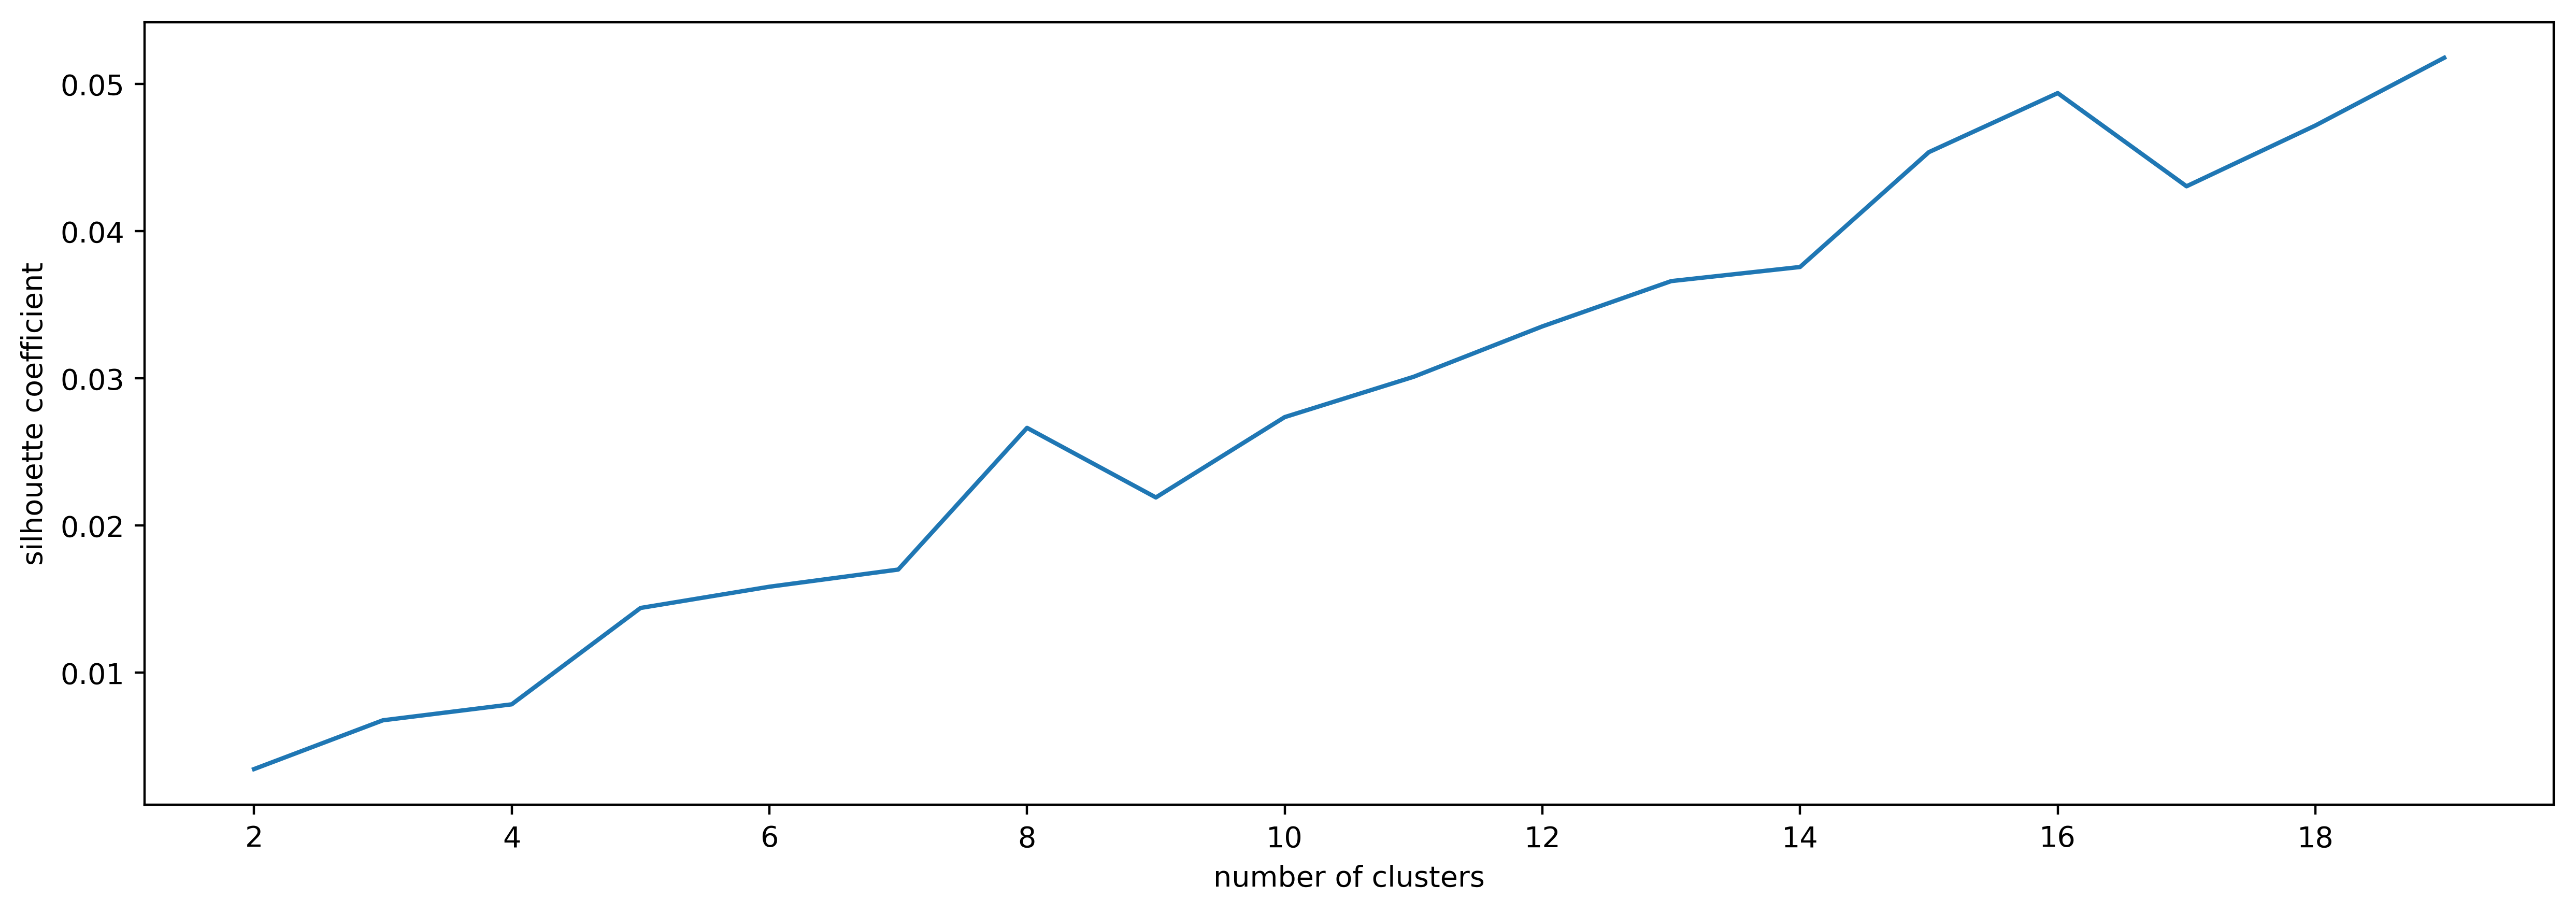

In [116]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(2, 20, step=2))
